### **BASKETBALL 3-POINTER SHOT TRACKING (COMPUTER VISION)**

**1. DATA PREPARATION**

In [ ]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio
!{sys.executable} -m pip install ultralytics
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


1.1. Frame Extraction

In [ ]:
import cv2
import os

video_folder = "/content/drive/MyDrive/Test_Videos"
output_folder = "/content/drive/MyDrive/Test_Videos/Frames"

os.makedirs(output_folder, exist_ok=True)

def extract_frames(video_path, output_folder, frame_skip=6):
    cap = cv2.VideoCapture(video_path)
    count = 0
    saved_count = 0

    video_name = os.path.splitext(os.path.basename(video_path))[0]

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_skip == 0:
            filename = f"{video_name}_frame_{saved_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, filename), frame)
            saved_count += 1

        count += 1

    cap.release()

for video in os.listdir(video_folder):
    extract_frames(os.path.join(video_folder, video), output_folder)

print("Frame extraction completed!")


Frame extraction completed!


1.2. Label Organization

In [ ]:
import os

image_dir = "/content/drive/MyDrive/Test_Videos/Frames"
label_dir = "/content/drive/MyDrive/Test_Videos/Labels"

images = os.listdir(image_dir)
labels = os.listdir(label_dir)

label_basenames = set([os.path.splitext(label)[0] for label in labels])

removed = 0

for img in images:
    img_name = os.path.splitext(img)[0]
    if img_name not in label_basenames:
        os.remove(os.path.join(image_dir, img))
        removed += 1

print(f"Removed {removed} unlabeled images.")


Removed 160 unlabeled images.


1.3. Train/Val Split

In [ ]:
import random
import shutil

base_path = "/content/drive/MyDrive/Test_Videos"

images_path = os.path.join(base_path, "Frames")
labels_path = os.path.join(base_path, "Labels")

train_img_path = os.path.join(images_path, "train")
val_img_path = os.path.join(images_path, "val")
train_lbl_path = os.path.join(labels_path, "train")
val_lbl_path = os.path.join(labels_path, "val")

os.makedirs(train_img_path, exist_ok=True)
os.makedirs(val_img_path, exist_ok=True)
os.makedirs(train_lbl_path, exist_ok=True)
os.makedirs(val_lbl_path, exist_ok=True)

all_images = os.listdir(images_path)
random.shuffle(all_images)

split_ratio = 0.8
split_index = int(len(all_images) * split_ratio)

train_images = all_images[:split_index]
val_images = all_images[split_index:]

for img in train_images:
    shutil.move(os.path.join(images_path, img), train_img_path)
    shutil.move(os.path.join(labels_path, img.replace(".jpg", ".txt")), train_lbl_path)

for img in val_images:
    shutil.move(os.path.join(images_path, img), val_img_path)
    shutil.move(os.path.join(labels_path, img.replace(".jpg", ".txt")), val_lbl_path)

print("Dataset split completed!")


Dataset split completed!


**2. YOLO Training**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolov8n.pt")  # nano version (fast & good for small dataset)

2.1. Removing Existing Cache Files due to Incorrect Naming of Folders

In [ ]:
import os

base = "/content/drive/MyDrive/Test_Videos"

# Remove old cache files
for file in ["Frames/train.cache", "Frames/val.cache"]:
    path = os.path.join(base, file)
    if os.path.exists(path):
        os.remove(path)
        print("Deleted:", path)


Deleted: /content/drive/MyDrive/Test_Videos/Frames/train.cache
Deleted: /content/drive/MyDrive/Test_Videos/Frames/val.cache


In [ ]:
import os

base = "/content/drive/MyDrive/Test_Videos"

os.rename(base + "/Frames", base + "/images")
os.rename(base + "/Labels", base + "/labels")

print("Folders renamed successfully.")


Folders renamed successfully.


2.2. Images and Labels Verification

In [ ]:
base = "/content/drive/MyDrive/Test_Videos"

print("Train images:", len(os.listdir(base + "/images/train")))
print("Train labels:", len(os.listdir(base + "/labels/train")))
print("Val images:", len(os.listdir(base + "/images/val")))
print("Val labels:", len(os.listdir(base + "/labels/val")))


Train images: 171
Train labels: 171
Val images: 41
Val labels: 41


2.3. Creation of YAML File

In [ ]:
data_yaml = """
train: /content/drive/MyDrive/Test_Videos/images/train
val: /content/drive/MyDrive/Test_Videos/images/val

nc: 3
names: ['player', 'ball', 'hoop']
"""

with open('/content/drive/MyDrive/Test_Videos/data.yaml', 'w') as f:
    f.write(data_yaml)

print("data.yaml created successfully!")


data.yaml created successfully!


2.4. YOLO Model Training

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/drive/MyDrive/Test_Videos/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    name="basketball_3pointer"
)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Test_Videos/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=basketball_3pointer, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dcb06130fe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

2.5. Model Validation

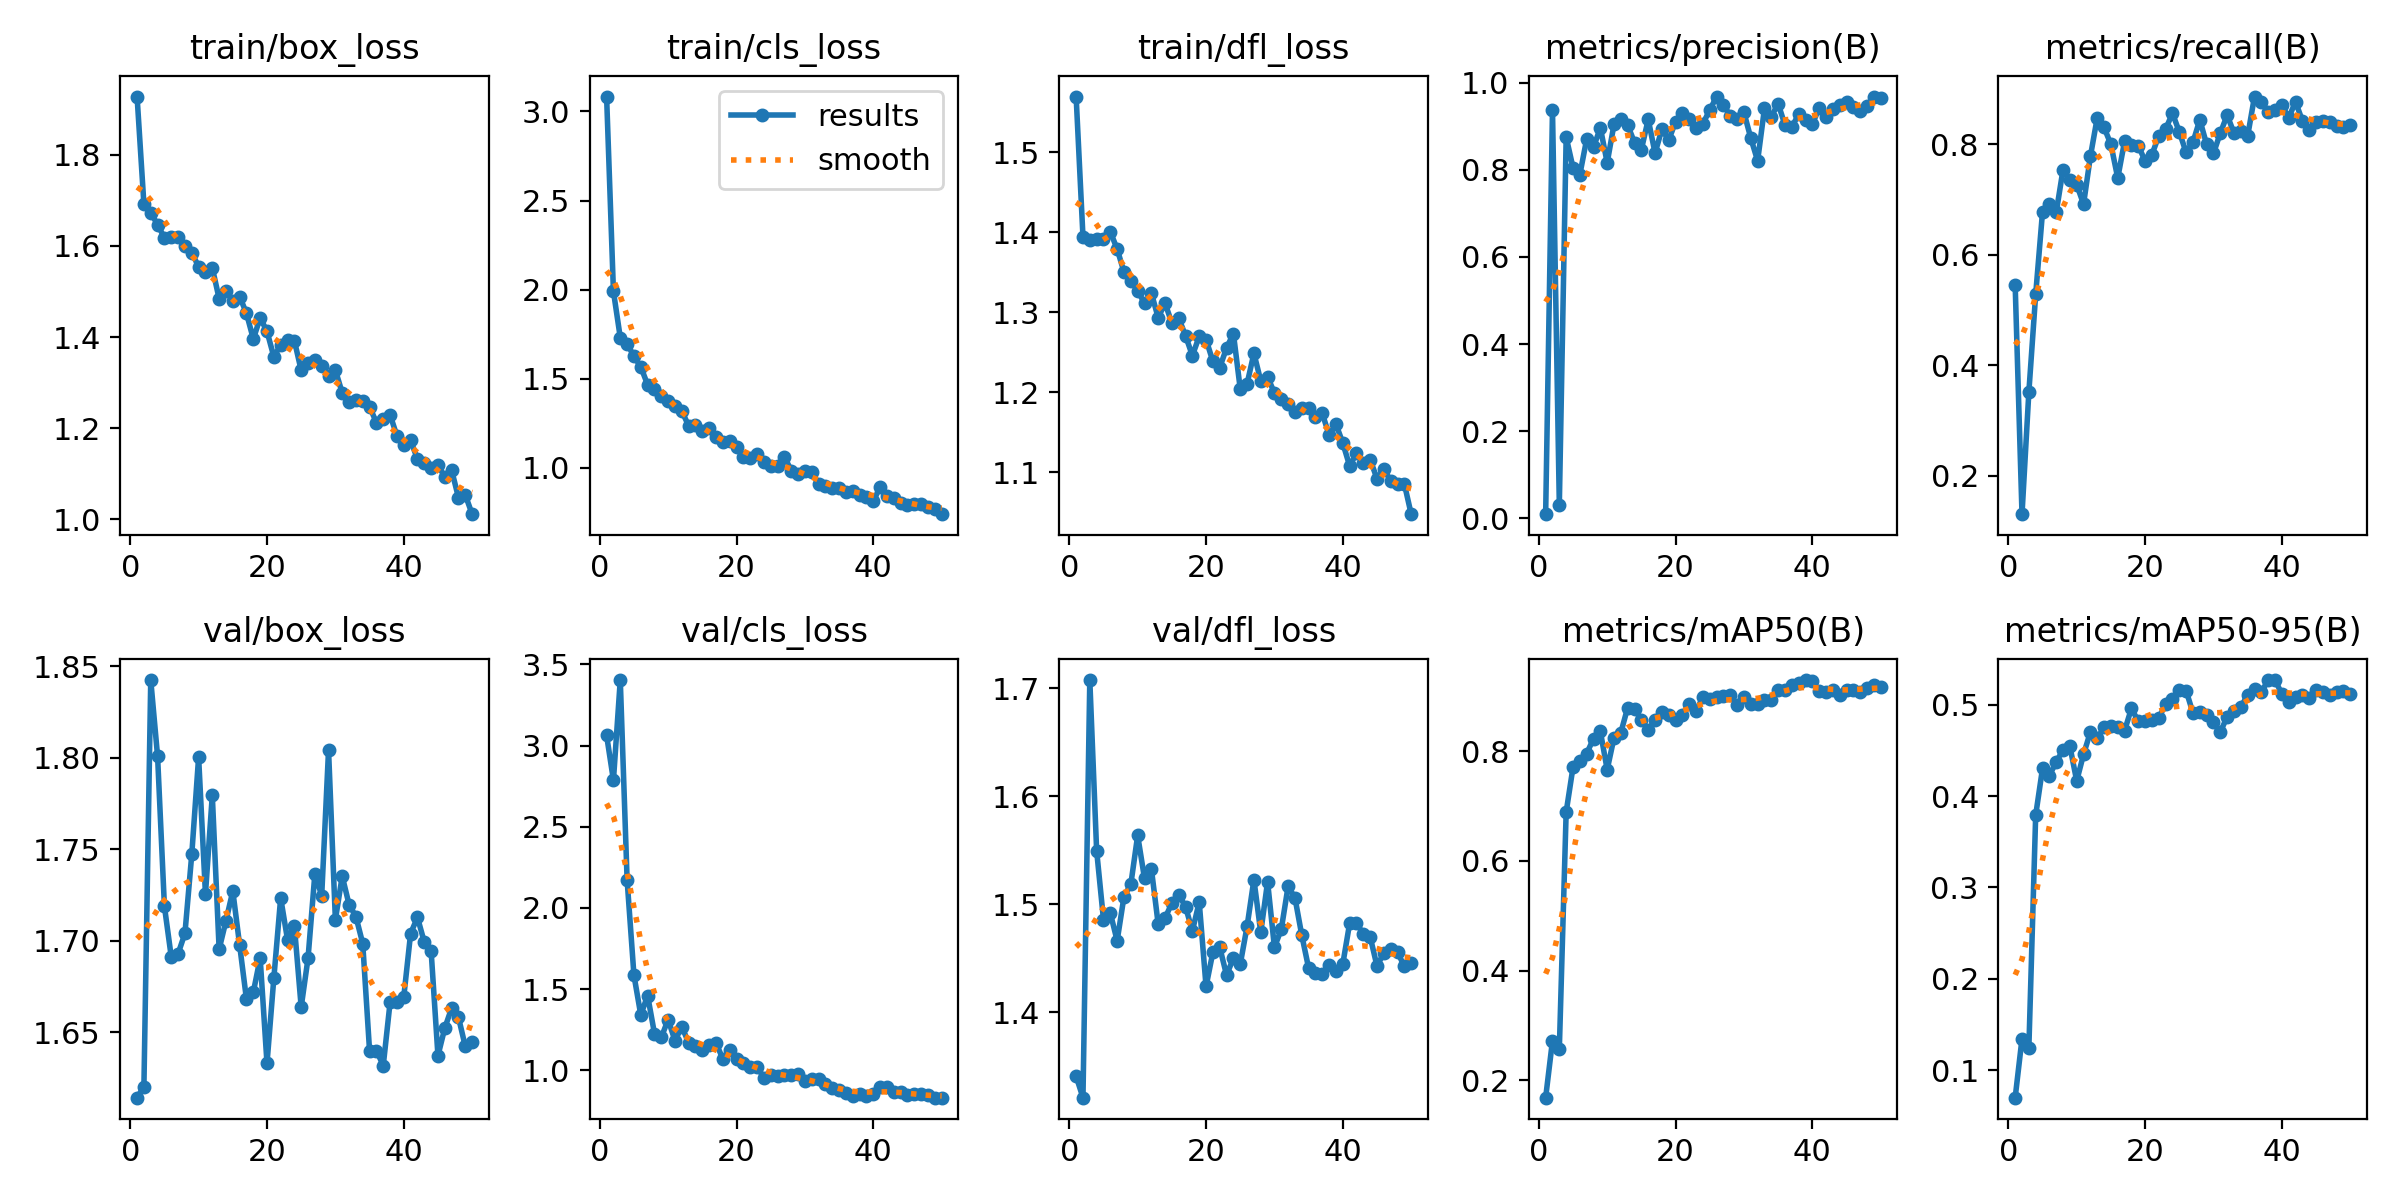

In [9]:
from IPython.display import Image
Image("/content/runs/detect/basketball_3pointer/results.png")


2.6. Model Metrics Output

In [10]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/basketball_3pointer/weights/best.pt")

metrics = model.val()


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 70.5±35.3 MB/s, size: 221.8 KB)
val: Scanning /content/drive/MyDrive/Test_Videos/labels/val.cache... 41 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 41/41 14.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.5it/s 2.1s
                   all         41        160      0.914      0.862      0.929      0.524
                player         28         99      0.822      0.869      0.896      0.429
                  ball         39         39      0.971      0.853      0.943      0.577
                  hoop         22         22      0.948      0.864       0.95      0.566
Speed: 7.7ms preprocess, 12.4ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to /content/runs/detect/val


2.7. Model Predict using Validation Images

In [12]:
model.predict(
    source="/content/drive/MyDrive/Test_Videos/images/val",
    save=True,
    conf=0.25
)



image 1/41 /content/drive/MyDrive/Test_Videos/images/val/video10_frame_19.jpg: 384x640 1 ball, 1 hoop, 45.7ms
image 2/41 /content/drive/MyDrive/Test_Videos/images/val/video10_frame_22.jpg: 384x640 1 hoop, 7.1ms
image 3/41 /content/drive/MyDrive/Test_Videos/images/val/video11_frame_19.jpg: 384x640 4 players, 1 ball, 7.0ms
image 4/41 /content/drive/MyDrive/Test_Videos/images/val/video11_frame_26.jpg: 384x640 6 players, 1 hoop, 7.4ms
image 5/41 /content/drive/MyDrive/Test_Videos/images/val/video11_frame_31.jpg: 384x640 4 players, 1 ball, 1 hoop, 7.7ms
image 6/41 /content/drive/MyDrive/Test_Videos/images/val/video12_frame_11.jpg: 384x640 1 ball, 1 hoop, 8.9ms
image 7/41 /content/drive/MyDrive/Test_Videos/images/val/video12_frame_12.jpg: 384x640 1 hoop, 7.4ms
image 8/41 /content/drive/MyDrive/Test_Videos/images/val/video12_frame_4.jpg: 384x640 4 players, 1 ball, 7.4ms
image 9/41 /content/drive/MyDrive/Test_Videos/images/val/video12_frame_6.jpg: 384x640 3 players, 2 balls, 7.5ms
image 10/41

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'player', 1: 'ball', 2: 'hoop'}
 obb: None
 orig_img: array([[[34, 36, 44],
         [34, 36, 44],
         [36, 35, 44],
         ...,
         [12,  6, 11],
         [12,  6, 11],
         [12,  6, 11]],
 
        [[33, 35, 43],
         [34, 36, 44],
         [36, 35, 44],
         ...,
         [12,  6, 11],
         [12,  6, 11],
         [12,  6, 11]],
 
        [[34, 33, 43],
         [36, 35, 45],
         [39, 35, 46],
         ...,
         [12,  6, 11],
         [12,  6, 11],
         [12,  6, 11]],
 
        ...,
 
        [[27, 20, 23],
         [28, 21, 24],
         [30, 21, 24],
         ...,
         [38, 32, 37],
         [37, 31, 36],
         [37, 31, 36]],
 
        [[29, 23, 24],
         [30, 24, 25],
         [31, 23, 24],
         ...,
         [42, 36, 41],
         [43, 37, 42],
         [43, 37, 42]],
 
     

2.8. Save Runs to Drive for Permanent Existance

In [13]:
!cp -r runs /content/drive/MyDrive/

**3. Pose Estimation using Mediapipe**

In [14]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [15]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread("/content/drive/MyDrive/Test_Videos/images/val/video12_frame_6.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = pose.process(image_rgb)

if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


AttributeError: module 'mediapipe' has no attribute 'solutions'

3.1. Installing Required Mediapipe Version

In [17]:
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.13


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.6
    Uninstalling protobuf-5.29.6:
      Successfully uninstalled protobuf-5.29.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.15.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.38.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 4.25.8 which is incompatible.


3.2. Import and Load Mediapipe

In [1]:
import mediapipe as mp


In [2]:
import mediapipe as mp

mp_pose = mp.solutions.pose
print("MediaPipe Pose loaded successfully!")


MediaPipe Pose loaded successfully!


3.3. Testing Pose Estimation on One Image

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

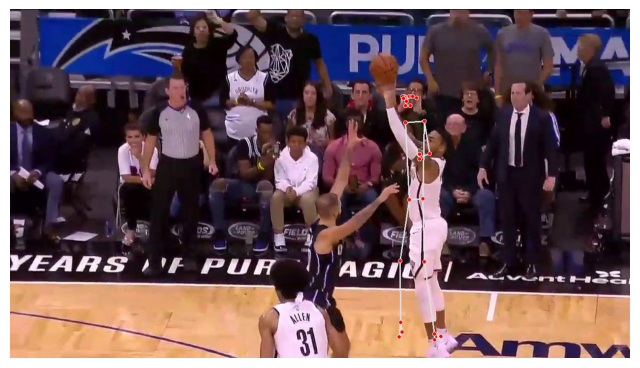

In [3]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

image = cv2.imread("/content/drive/MyDrive/Test_Videos/images/val/video12_frame_6.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = pose.process(image_rgb)

if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


3.4. Loading Trained YOLO Model

In [4]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/runs/detect/basketball_3pointer/weights/best.pt")


3.5. Detection + Pose Estimation


0: 384x640 3 players, 2 balls, 53.7ms
Speed: 3.3ms preprocess, 53.7ms inference, 20.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

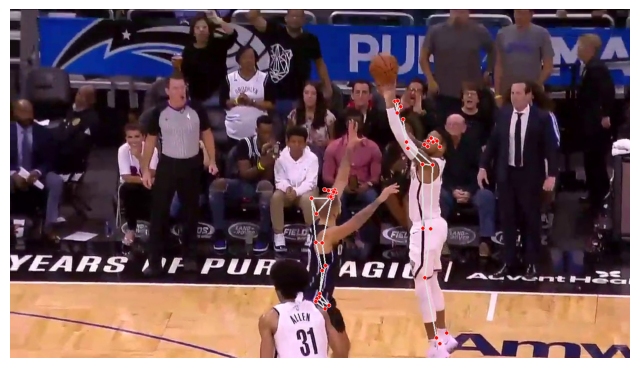

In [5]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

image_path = "/content/drive/MyDrive/Test_Videos/images/val/video12_frame_6.jpg"
image = cv2.imread(image_path)

# Run YOLO detection
results = model(image)

for box in results[0].boxes:
    cls_id = int(box.cls[0])

    # class 0 = player (based on your classes.txt order)
    if cls_id == 0:
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Crop detected player
        player_crop = image[y1:y2, x1:x2]

        # Convert to RGB for MediaPipe
        player_rgb = cv2.cvtColor(player_crop, cv2.COLOR_BGR2RGB)

        pose_results = pose.process(player_rgb)

        if pose_results.pose_landmarks:
            mp_drawing.draw_landmarks(
                player_crop,
                pose_results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS
            )

        # Put modified crop back
        image[y1:y2, x1:x2] = player_crop

# Display result
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


3.6. Adding Bounding Boxes

In [6]:
cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)


array([[[ 43,  32,  42],
        [ 41,  30,  40],
        [ 39,  28,  38],
        ...,
        [ 15,  15,  21],
        [ 13,  13,  19],
        [ 12,  12,  18]],

       [[ 36,  25,  35],
        [ 35,  24,  34],
        [ 32,  21,  31],
        ...,
        [ 23,  23,  29],
        [ 23,  23,  29],
        [ 23,  23,  29]],

       [[ 55,  44,  54],
        [ 54,  43,  53],
        [ 52,  41,  51],
        ...,
        [ 37,  37,  43],
        [ 39,  39,  45],
        [ 41,  41,  47]],

       ...,

       [[131, 175, 246],
        [131, 175, 246],
        [131, 175, 246],
        ...,
        [ 75,  33,  56],
        [ 72,  33,  55],
        [ 72,  33,  54]],

       [[131, 175, 246],
        [131, 175, 246],
        [131, 175, 246],
        ...,
        [ 73,  34,  56],
        [ 75,  34,  55],
        [ 73,  33,  51]],

       [[131, 175, 246],
        [131, 175, 246],
        [131, 175, 246],
        ...,
        [ 73,  34,  55],
        [ 76,  35,  56],
        [ 73,  33,  51]]

In [7]:
if cls_id == 0:
    x1, y1, x2, y2 = map(int, box.xyxy[0])

    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)

    player_crop = image[y1:y2, x1:x2]
    ...


3.7. Bounding Box & Skeleton Check

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

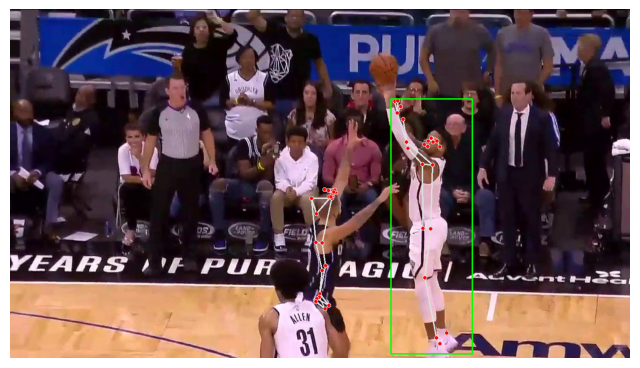

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


3.8. Loop Through All Validaton Images, Apply Detection and Extract Skeleton

In [14]:
import os
import cv2
import csv
import numpy as np
from ultralytics import YOLO
import mediapipe as mp


# PATHS

base_path = "/content/drive/MyDrive/Test_Videos"
val_images_path = base_path + "/images/val"
output_path = base_path + "/Pose_Output"

os.makedirs(output_path, exist_ok=True)


# LOAD YOLO MODEL

model = YOLO("/content/runs/detect/basketball_3pointer/weights/best.pt")


# SETUP MEDIAPIPE

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils


# CSV FILE FOR LANDMARKS

csv_file = open(base_path + "/pose_landmarks.csv", "w", newline="")
csv_writer = csv.writer(csv_file)

# Write header
header = ["image_name"]
for i in range(33):
    header += [f"x{i}", f"y{i}", f"z{i}"]
csv_writer.writerow(header)


# LOOP THROUGH IMAGES

for image_name in os.listdir(val_images_path):

    image_path = os.path.join(val_images_path, image_name)
    image = cv2.imread(image_path)

    if image is None:
        continue

    results = model(image)[0]

    for box in results.boxes:
        class_id = int(box.cls[0])

        # Assuming class 0 = player
        if class_id == 0:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            player_crop = image[y1:y2, x1:x2]

            if player_crop.size == 0:
                continue

            rgb_crop = cv2.cvtColor(player_crop, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(rgb_crop)

            if pose_results.pose_landmarks:

                # Draw skeleton on original image
                mp_drawing.draw_landmarks(
                    player_crop,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS
                )

                # Save coordinates
                row = [image_name]
                for lm in pose_results.pose_landmarks.landmark:
                    row += [lm.x, lm.y, lm.z]

                csv_writer.writerow(row)

            # Put crop back into original image
            image[y1:y2, x1:x2] = player_crop

    # Save output image
    cv2.imwrite(os.path.join(output_path, image_name), image)

csv_file.close()

print("✅ Processing Completed")



0: 384x640 3 players, 2 balls, 16.5ms
Speed: 3.1ms preprocess, 16.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


0: 384x640 4 players, 1 ball, 17.7ms
Speed: 3.6ms preprocess, 17.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 hoop, 10.8ms
Speed: 3.5ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 hoop, 10.7ms
Speed: 3.6ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 players, 1 ball, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 players, 1 ball, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 1 ball, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 1 ball, 16.8ms
Speed: 3.7ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 1 ball, 14.2ms
Speed: 3.0ms preprocess, 14.2ms in